In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, recall_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

**Credit scoring** is an important banking task.

The standard approach is to build classic machine learning models such as logistic regression and gradient boosting on tabular data, including using aggregations from some sequential data such as customer transaction histories.

### Field descriptions:
- id - identifier of the application
- <span style = 'color : red'> **flag** </span> - target (target variable)
- pre_since_opened - days from credit opening date to data collection date
- pre_since_confirmed - days from credit information confirmation date till data collection date
- pre_pterm - planned number of days from credit opening date to closing date
- pre_fterm - actual number of days from credit opening date to closing date
- pre_till_pclose - planned number of days from data collection date until closing loan date
- pre_till_fclose - actual number of days from data collection date until closing loan date
- pre_loans_credit_limit - credit limit
- pre_loans_next_pay_summ - amount of the next loan payment
- pre_loans_outstanding - outstanding loan amount
- pre_loans_total_overdue - current overdue amount
- pre_loans_max_overdue_sum - maximum overdue amount
- pre_loans_credit_cost_rate - total cost of credit
- pre_loans5 - number of delinquencies of up to 5 days
- pre_loans530 - number of delinquencies from 5 to 30 days
- pre_loans3060 - number of delinquencies from 30 to 60 days
- pre_loans6090 - number of delinquencies from 60 to 90 days
- pre_loans90 - number of delinquencies of more than 90 days
- is_zero_loans_5 - flag: no delinquencies of up to 5 days
- is_zero_loans_530 - flag: no delinquencies of 5 to 30 days
- is_zero_loans_3060 - flag: no delinquencies of 30 to 60 days
- is_zero_loans_6090 - flag: no delinquencies of 60 to 90 days
- is_zero_loans90 - flag: no delinquencies of more than 90 days
- pre_util - ratio of outstanding loan amount to credit limit
- pre_over2limit - ratio of currently overdue debt to credit limit
- pre_maxover2limit - ratio of maximum overdue debt to credit limit
- is_zero_util - flag: ratio of outstanding loan amount to credit limit equals 0
- is_zero_over2limit - flag: ratio of current overdue debt to credit limit equals 0
- is_zero_maxover2limit - flag: ratio of maximum overdue debt to credit limit equals 0
- **<span style = 'color : blue'> enc_paym_{0…n} </span>** - monthly payment statuses of the last n months
- enc_loans_account_holder_type - type of relation to the loan
- enc_loans_credit_status - credit status
- enc_loans_account_cur - currency of the loan
- enc_loans_credit_type - credit type
- pclose_flag - flag: planned number of days from opening date to closing date of the loan
- fclose_flag - flag: actual number of days from credit opening date to closing date undefined

### Read the data

In [2]:
df_train = pd.read_parquet('./P03_train.pq')
df_test = pd.read_parquet('./P03_test.pq')

In [76]:
df_test = pd.read_parquet('./P03_test.pq')

### EDA - Exploratory Data Analysis

In [3]:
df_train.sample(5)

,id,flag,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
62182,245473,0,7,6,4,8,1,11,17,3,...,3,3,3,4,1,2,4,1,1,1
25902,172253,0,17,11,8,11,16,12,2,2,...,3,3,3,4,1,3,2,1,0,0
172193,33246,0,19,16,1,8,14,11,11,2,...,3,3,3,4,1,2,3,1,0,1
65877,171716,0,11,9,4,8,1,11,14,2,...,3,3,3,4,4,2,1,1,1,1
64695,39601,0,12,9,6,8,0,11,2,0,...,3,3,3,4,1,2,0,1,0,1


In [4]:
print("No. of rows : ", df_train.shape[0])
print("No. of columns : ", df_train.shape[1])

No. of rows :  175000
No. of columns :  61


In [5]:
df_train.describe()

,id,flag,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
count,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,...,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000,175000.000000
mean,124988.536383,0.031006,10.594600,7.928571,7.960674,8.480663,6.470000,9.372623,9.631691,2.677589,...,2.725520,2.742063,2.757234,3.877903,1.032274,2.218137,3.329383,1.000206,0.276686,0.468869
std,72212.682773,0.173334,5.875207,4.216644,5.444405,3.594472,5.205496,3.270286,5.754680,1.790457,...,0.857159,0.833652,0.811288,0.587919,0.285895,0.450885,1.007710,0.028081,0.447361,0.499031
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62467.500000,0.000000,7.000000,6.000000,4.000000,8.000000,1.000000,8.000000,5.000000,2.000000,...,3.000000,3.000000,3.000000,4.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000
50%,125015.500000,0.000000,11.000000,9.000000,6.000000,8.000000,8.000000,11.000000,10.000000,2.000000,...,3.000000,3.000000,3.000000,4.000000,1.000000,2.000000,4.000000,1.000000,0.000000,0.000000
75%,187562.250000,0.000000,17.000000,9.000000,14.000000,9.000000,11.000000,11.000000,15.000000,4.000000,...,3.000000,3.000000,3.000000,4.000000,1.000000,2.000000,4.000000,1.000000,1.000000,1.000000
max,249999.000000,1.000000,19.000000,17.000000,17.000000,16.000000,16.000000,15.000000,19.000000,6.000000,...,3.000000,3.000000,3.000000,4.000000,6.000000,6.000000,5.000000,2.000000,1.000000,1.000000


In [6]:
df_train.isna().mean().to_frame(name='% of missing values')

,% of missing values
id,0.0
flag,0.0
pre_since_opened,0.0
pre_since_confirmed,0.0
pre_pterm,0.0
...,...
enc_loans_credit_status,0.0
enc_loans_credit_type,0.0
enc_loans_account_cur,0.0
pclose_flag,0.0


In [3]:
df_train.drop(['id'], axis='columns', inplace=True)
df_test.drop(['id'], axis='columns', inplace=True)

In [9]:
df_train.duplicated().sum()

31024

In [4]:
df_train.drop_duplicates(inplace=True)
df_train.shape

(143976, 60)

In [11]:
df_train.flag.value_counts()

flag
0    138822
1      5154
Name: count, dtype: int64

In [12]:
df_train.nunique().to_frame("# of unique values")

,# of unique values
flag,2
pre_since_opened,20
pre_since_confirmed,18
pre_pterm,18
pre_fterm,17
pre_till_pclose,17
pre_till_fclose,16
pre_loans_credit_limit,20
pre_loans_next_pay_summ,7
pre_loans_outstanding,5


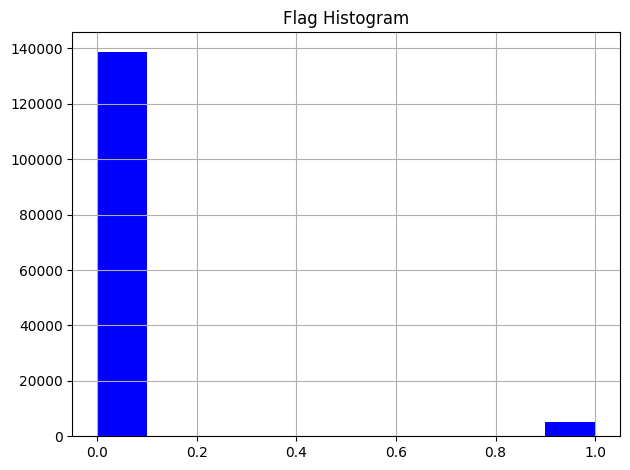

In [13]:
fig, ax = plt.subplots()

df_train.flag.hist(color='blue', ax=ax)
plt.title('Flag Histogram')
plt.tight_layout()
plt.show()

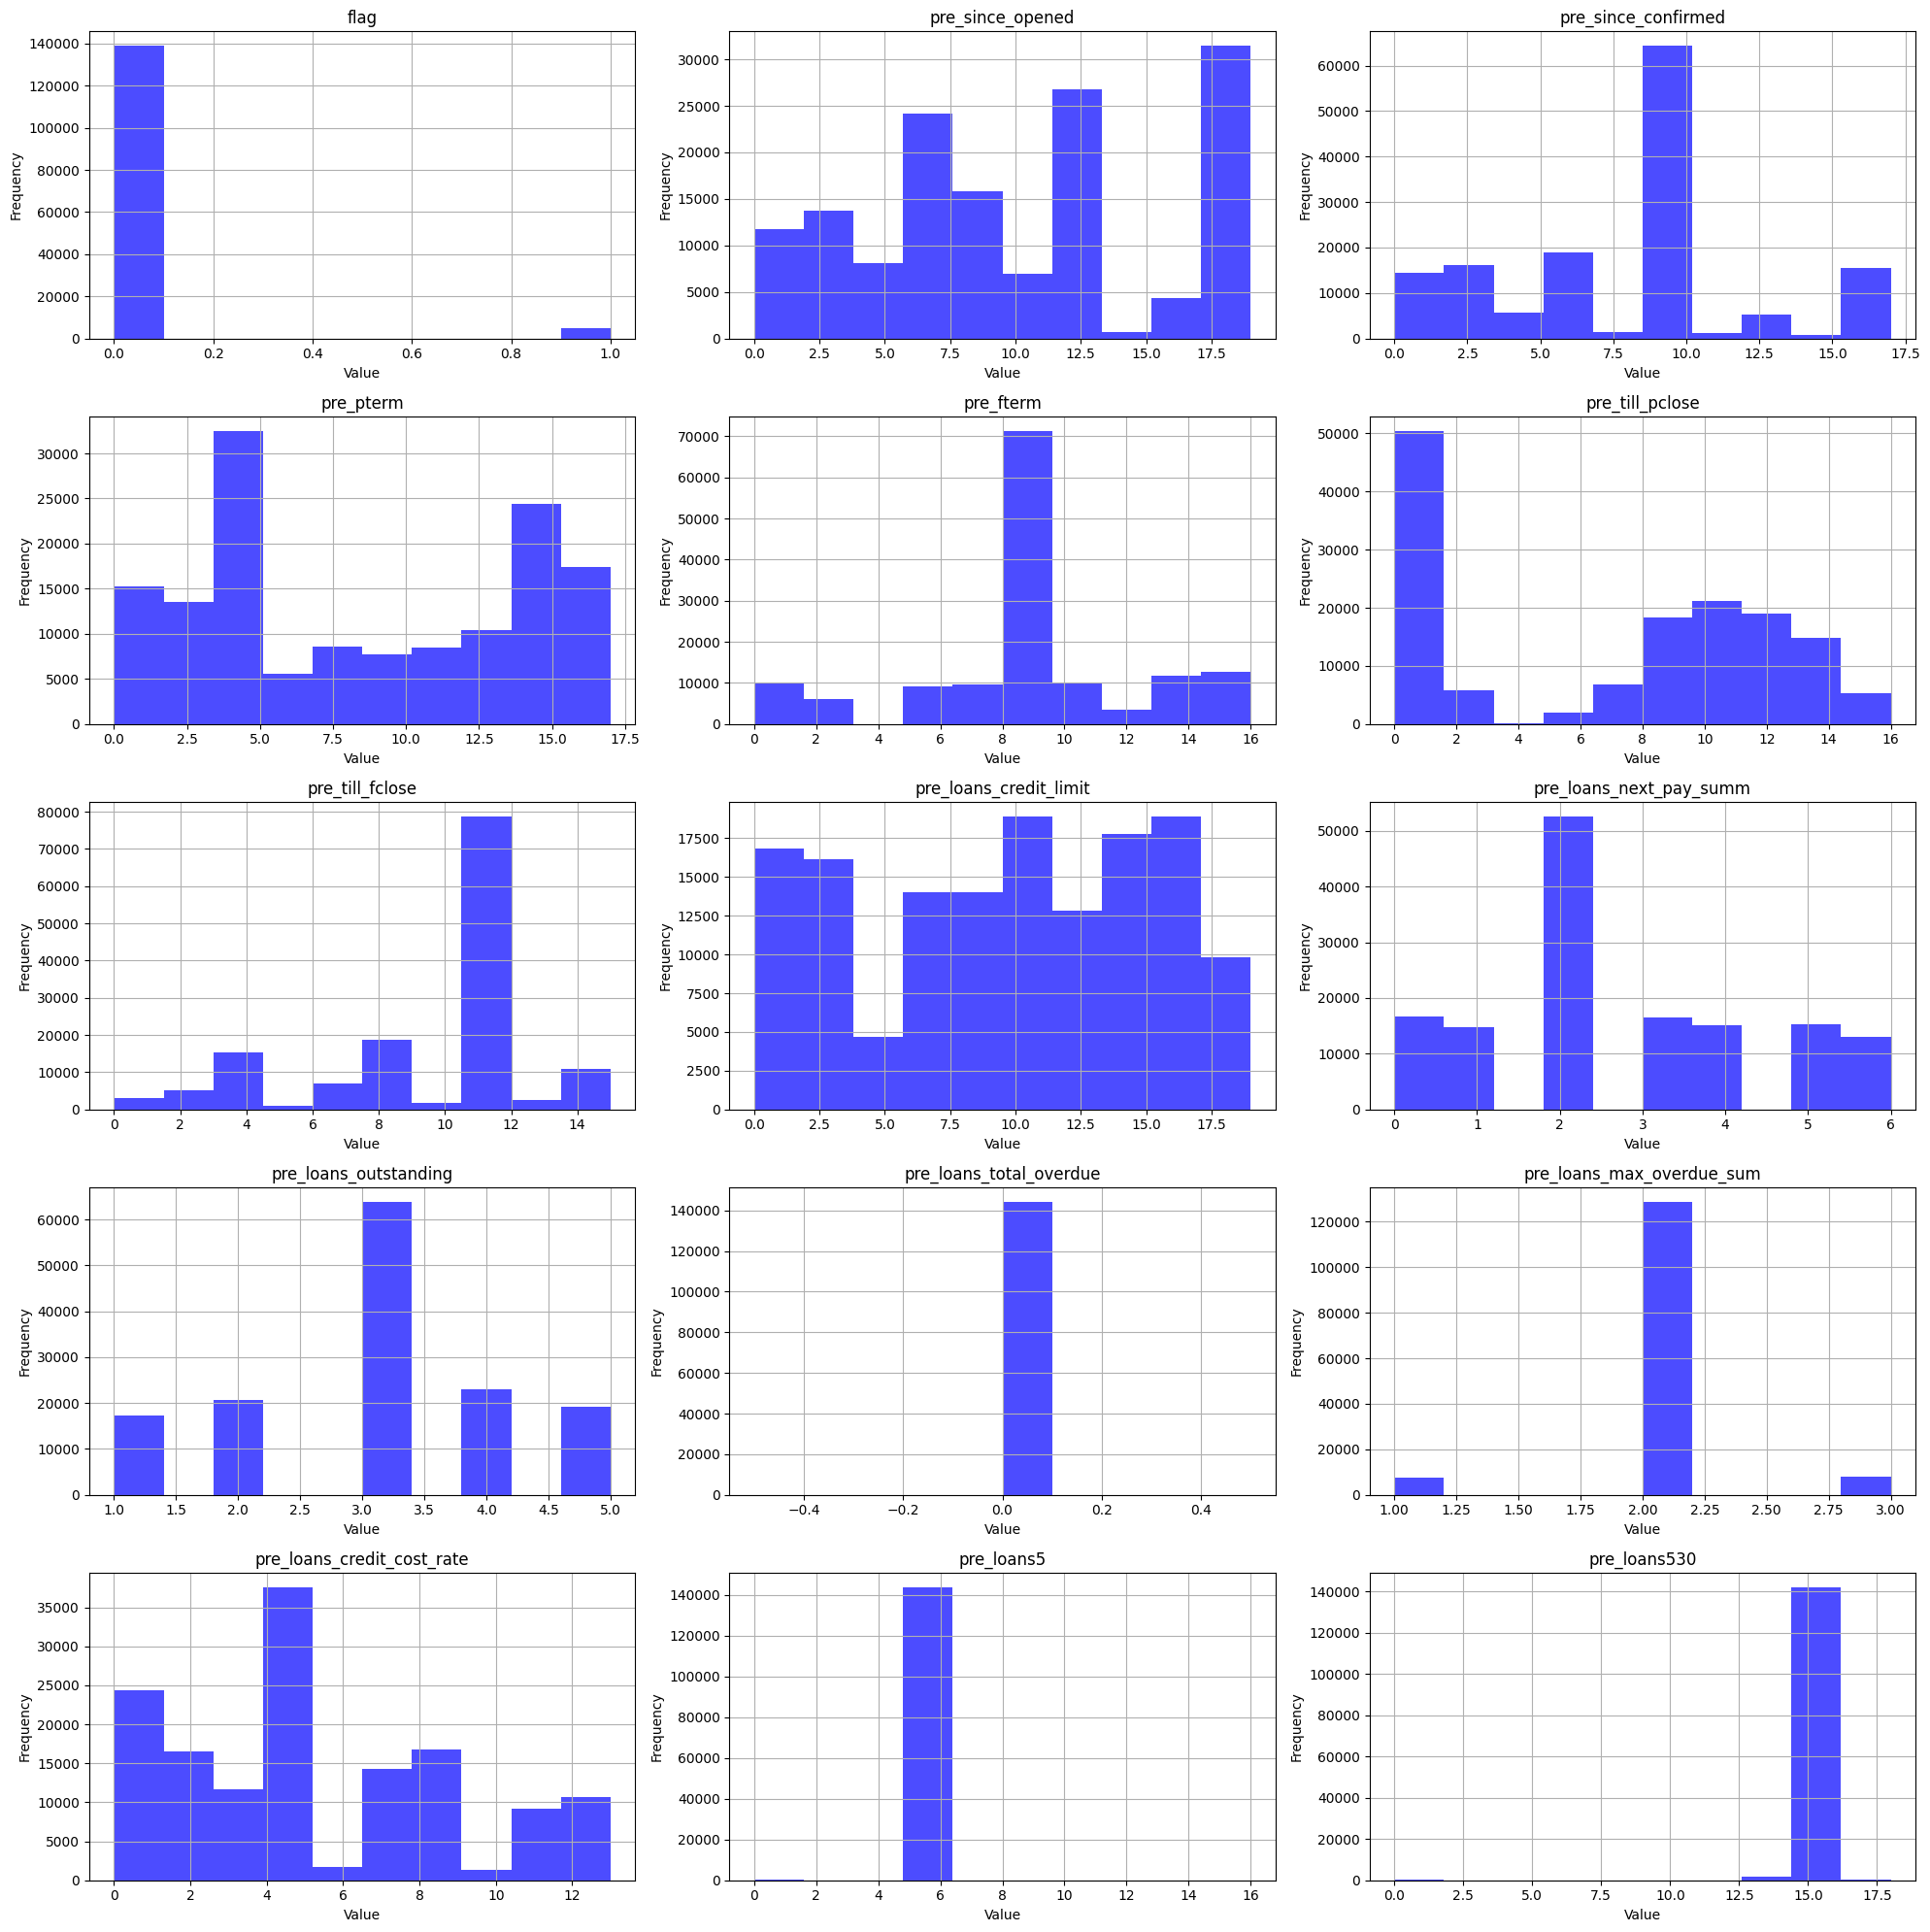

In [16]:
num_rows = 5
num_cols = 3
columns_to_plot = df_train.columns[:15]
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

axes_flat = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes_flat[i]
    df_train[column].hist(ax=ax, color='blue', alpha=0.7)
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

for i in range(len(columns_to_plot), num_rows * num_cols):
    axes_flat[i].remove()

plt.tight_layout()
plt.show()

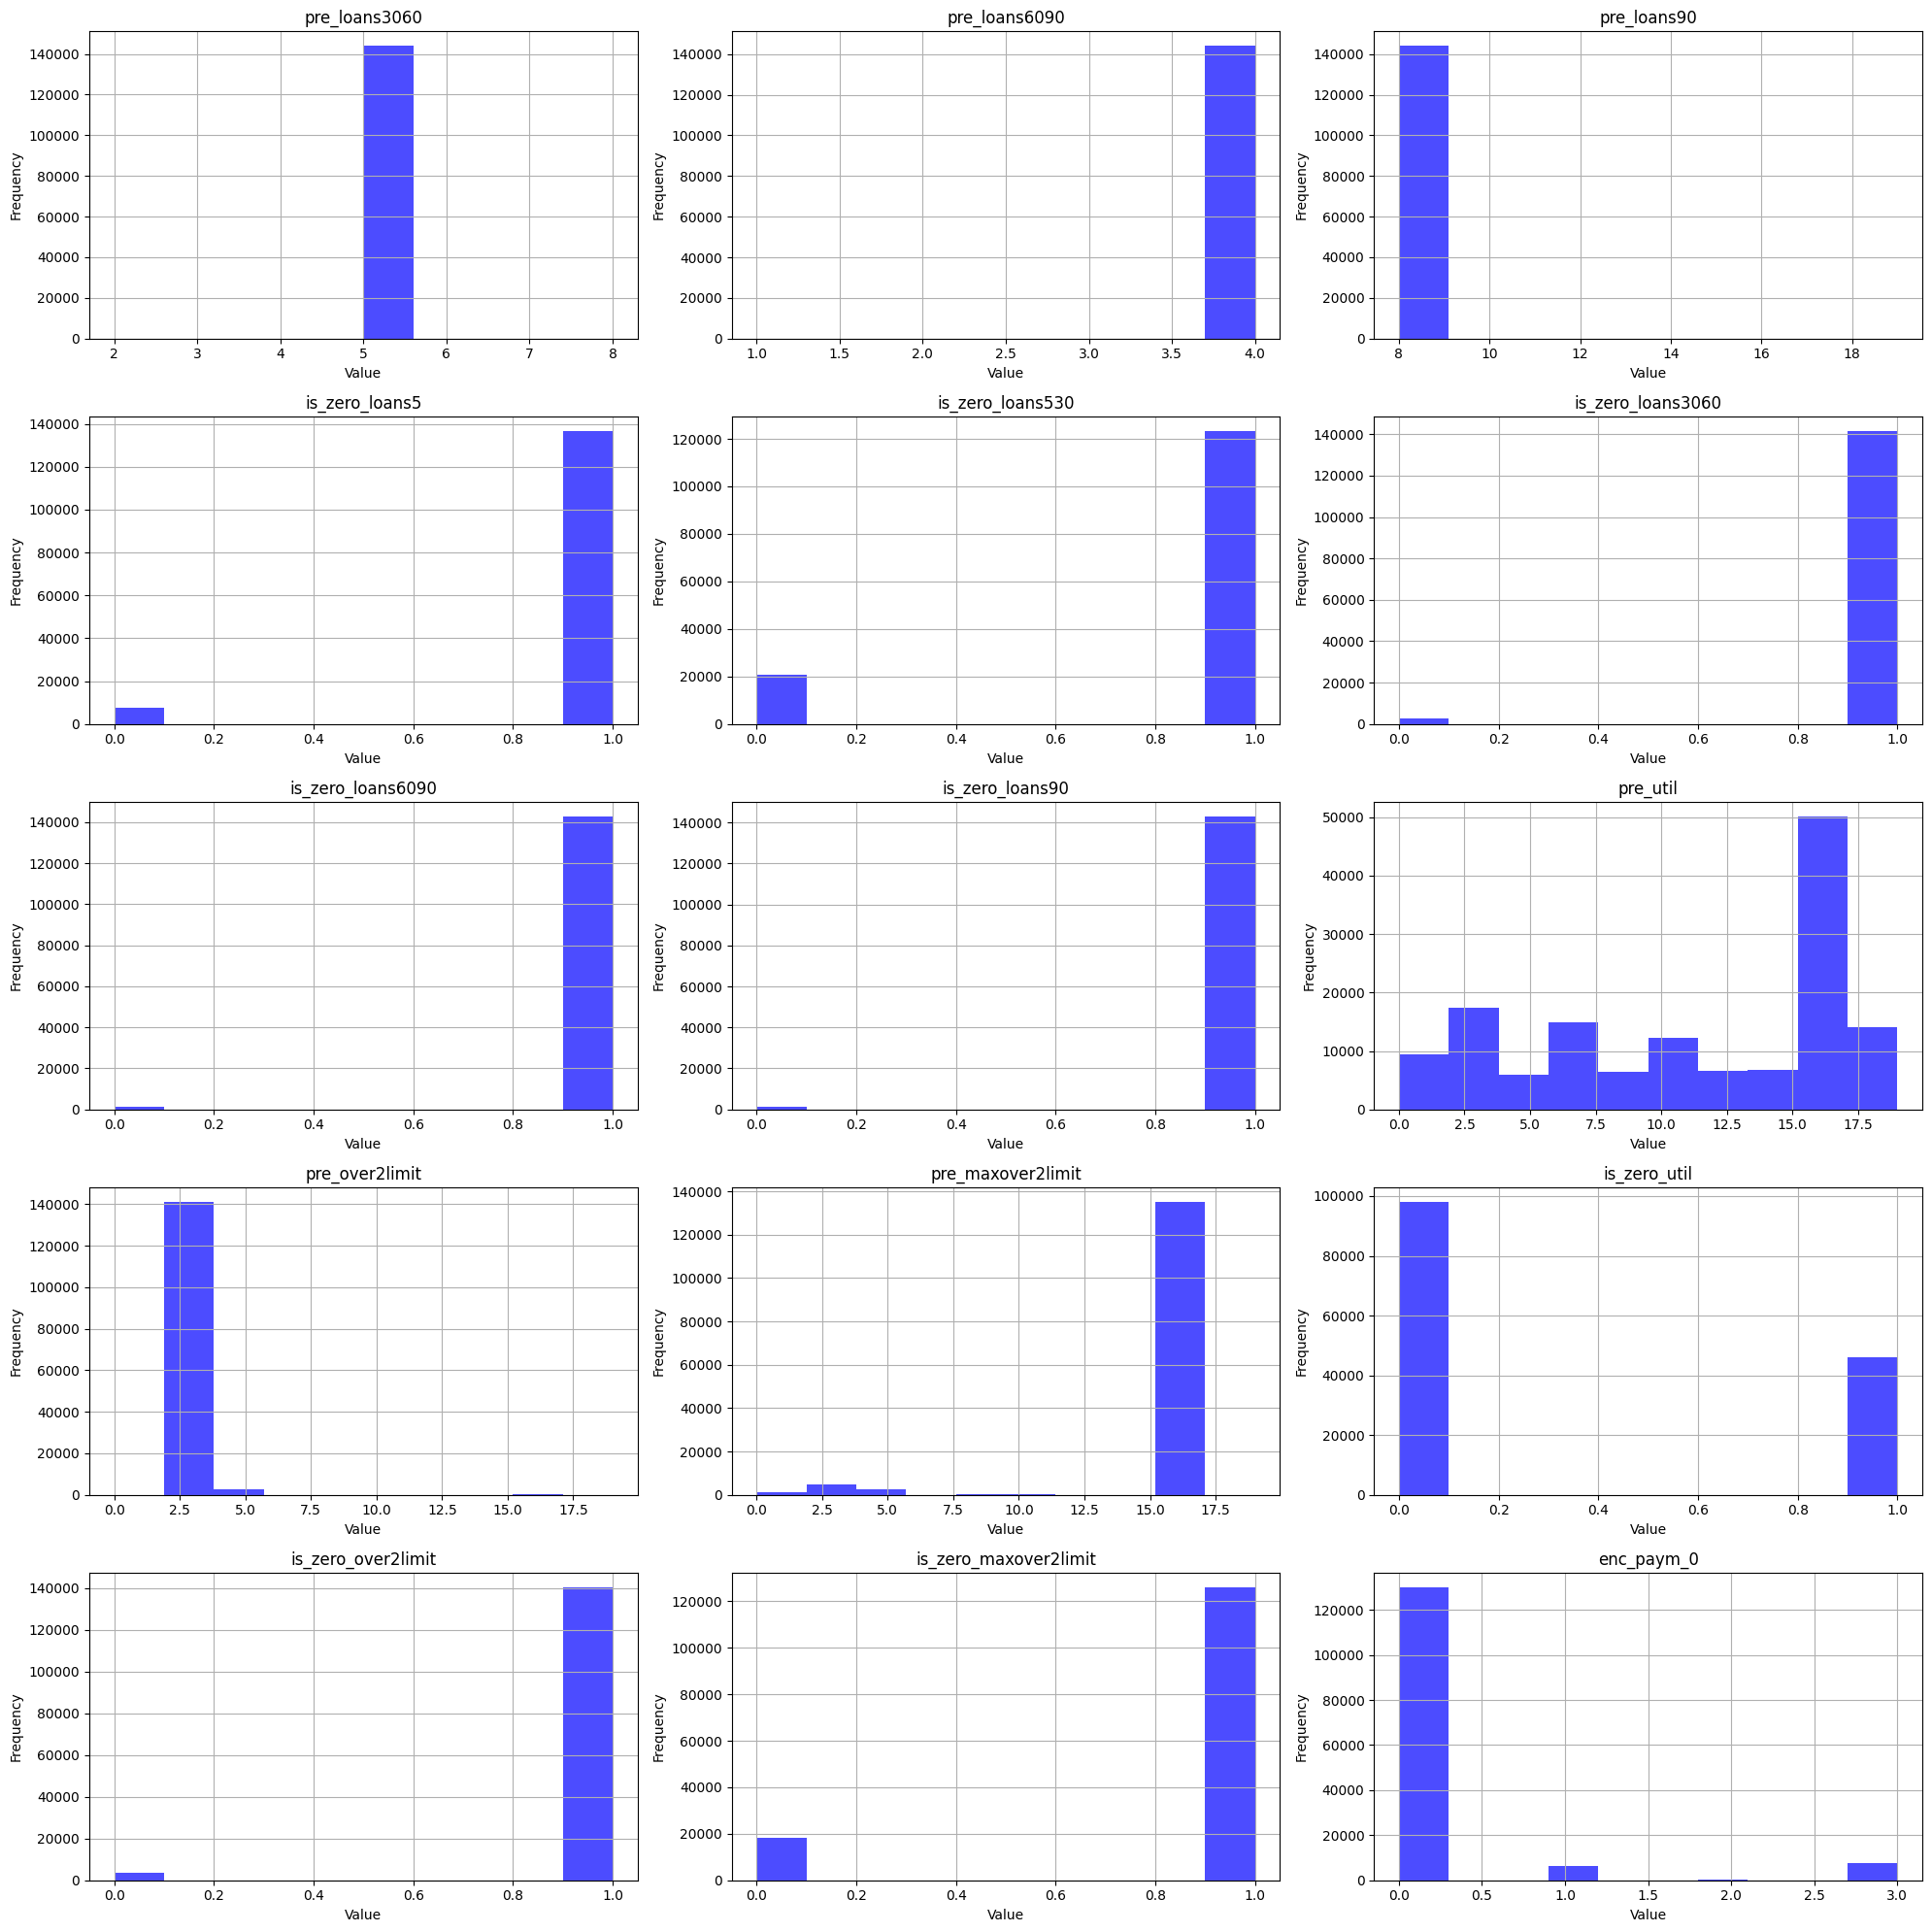

In [17]:
num_rows = 5
num_cols = 3
columns_to_plot = df_train.columns[15:30]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

axes_flat = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes_flat[i]
    df_train[column].hist(ax=ax, color='blue', alpha=0.7)
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

for i in range(len(columns_to_plot), num_rows * num_cols):
    axes_flat[i].remove()

plt.tight_layout()
plt.show()

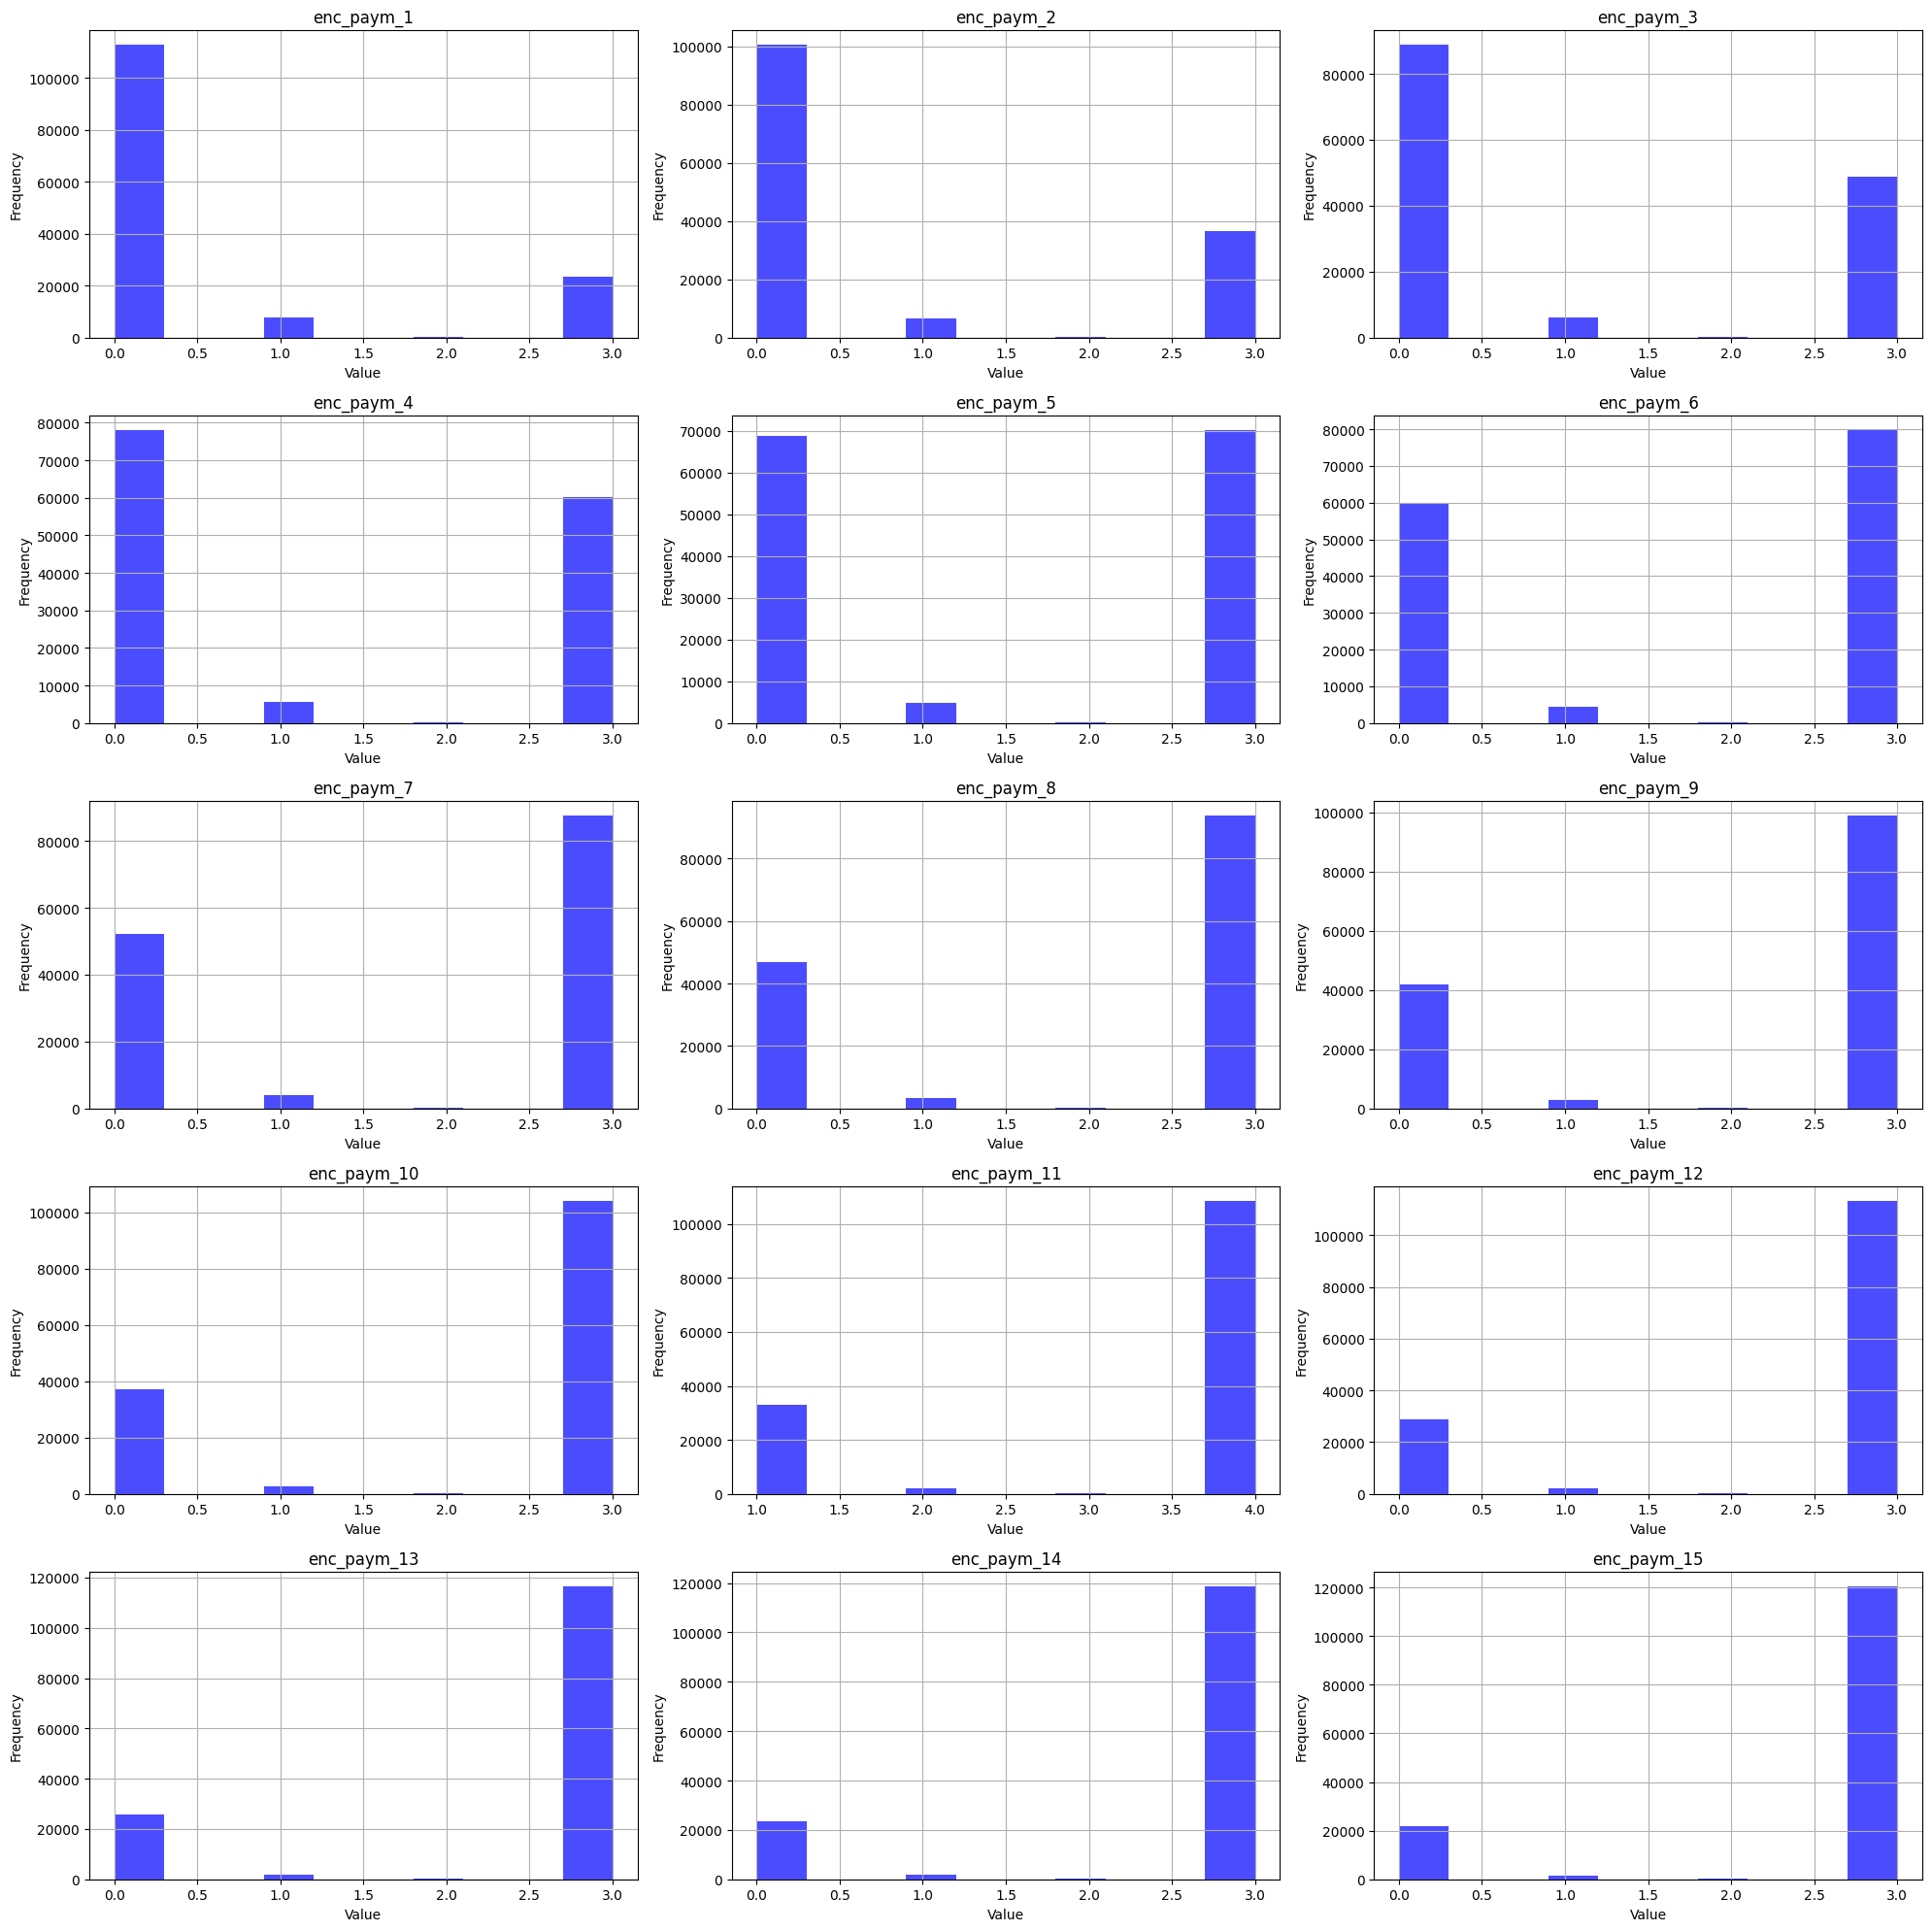

In [18]:
num_rows = 5
num_cols = 3
columns_to_plot = df_train.columns[30:45]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

axes_flat = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes_flat[i]
    df_train[column].hist(ax=ax, color='blue', alpha=0.7)
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

for i in range(len(columns_to_plot), num_rows * num_cols):
    axes_flat[i].remove()

plt.tight_layout()
plt.show()

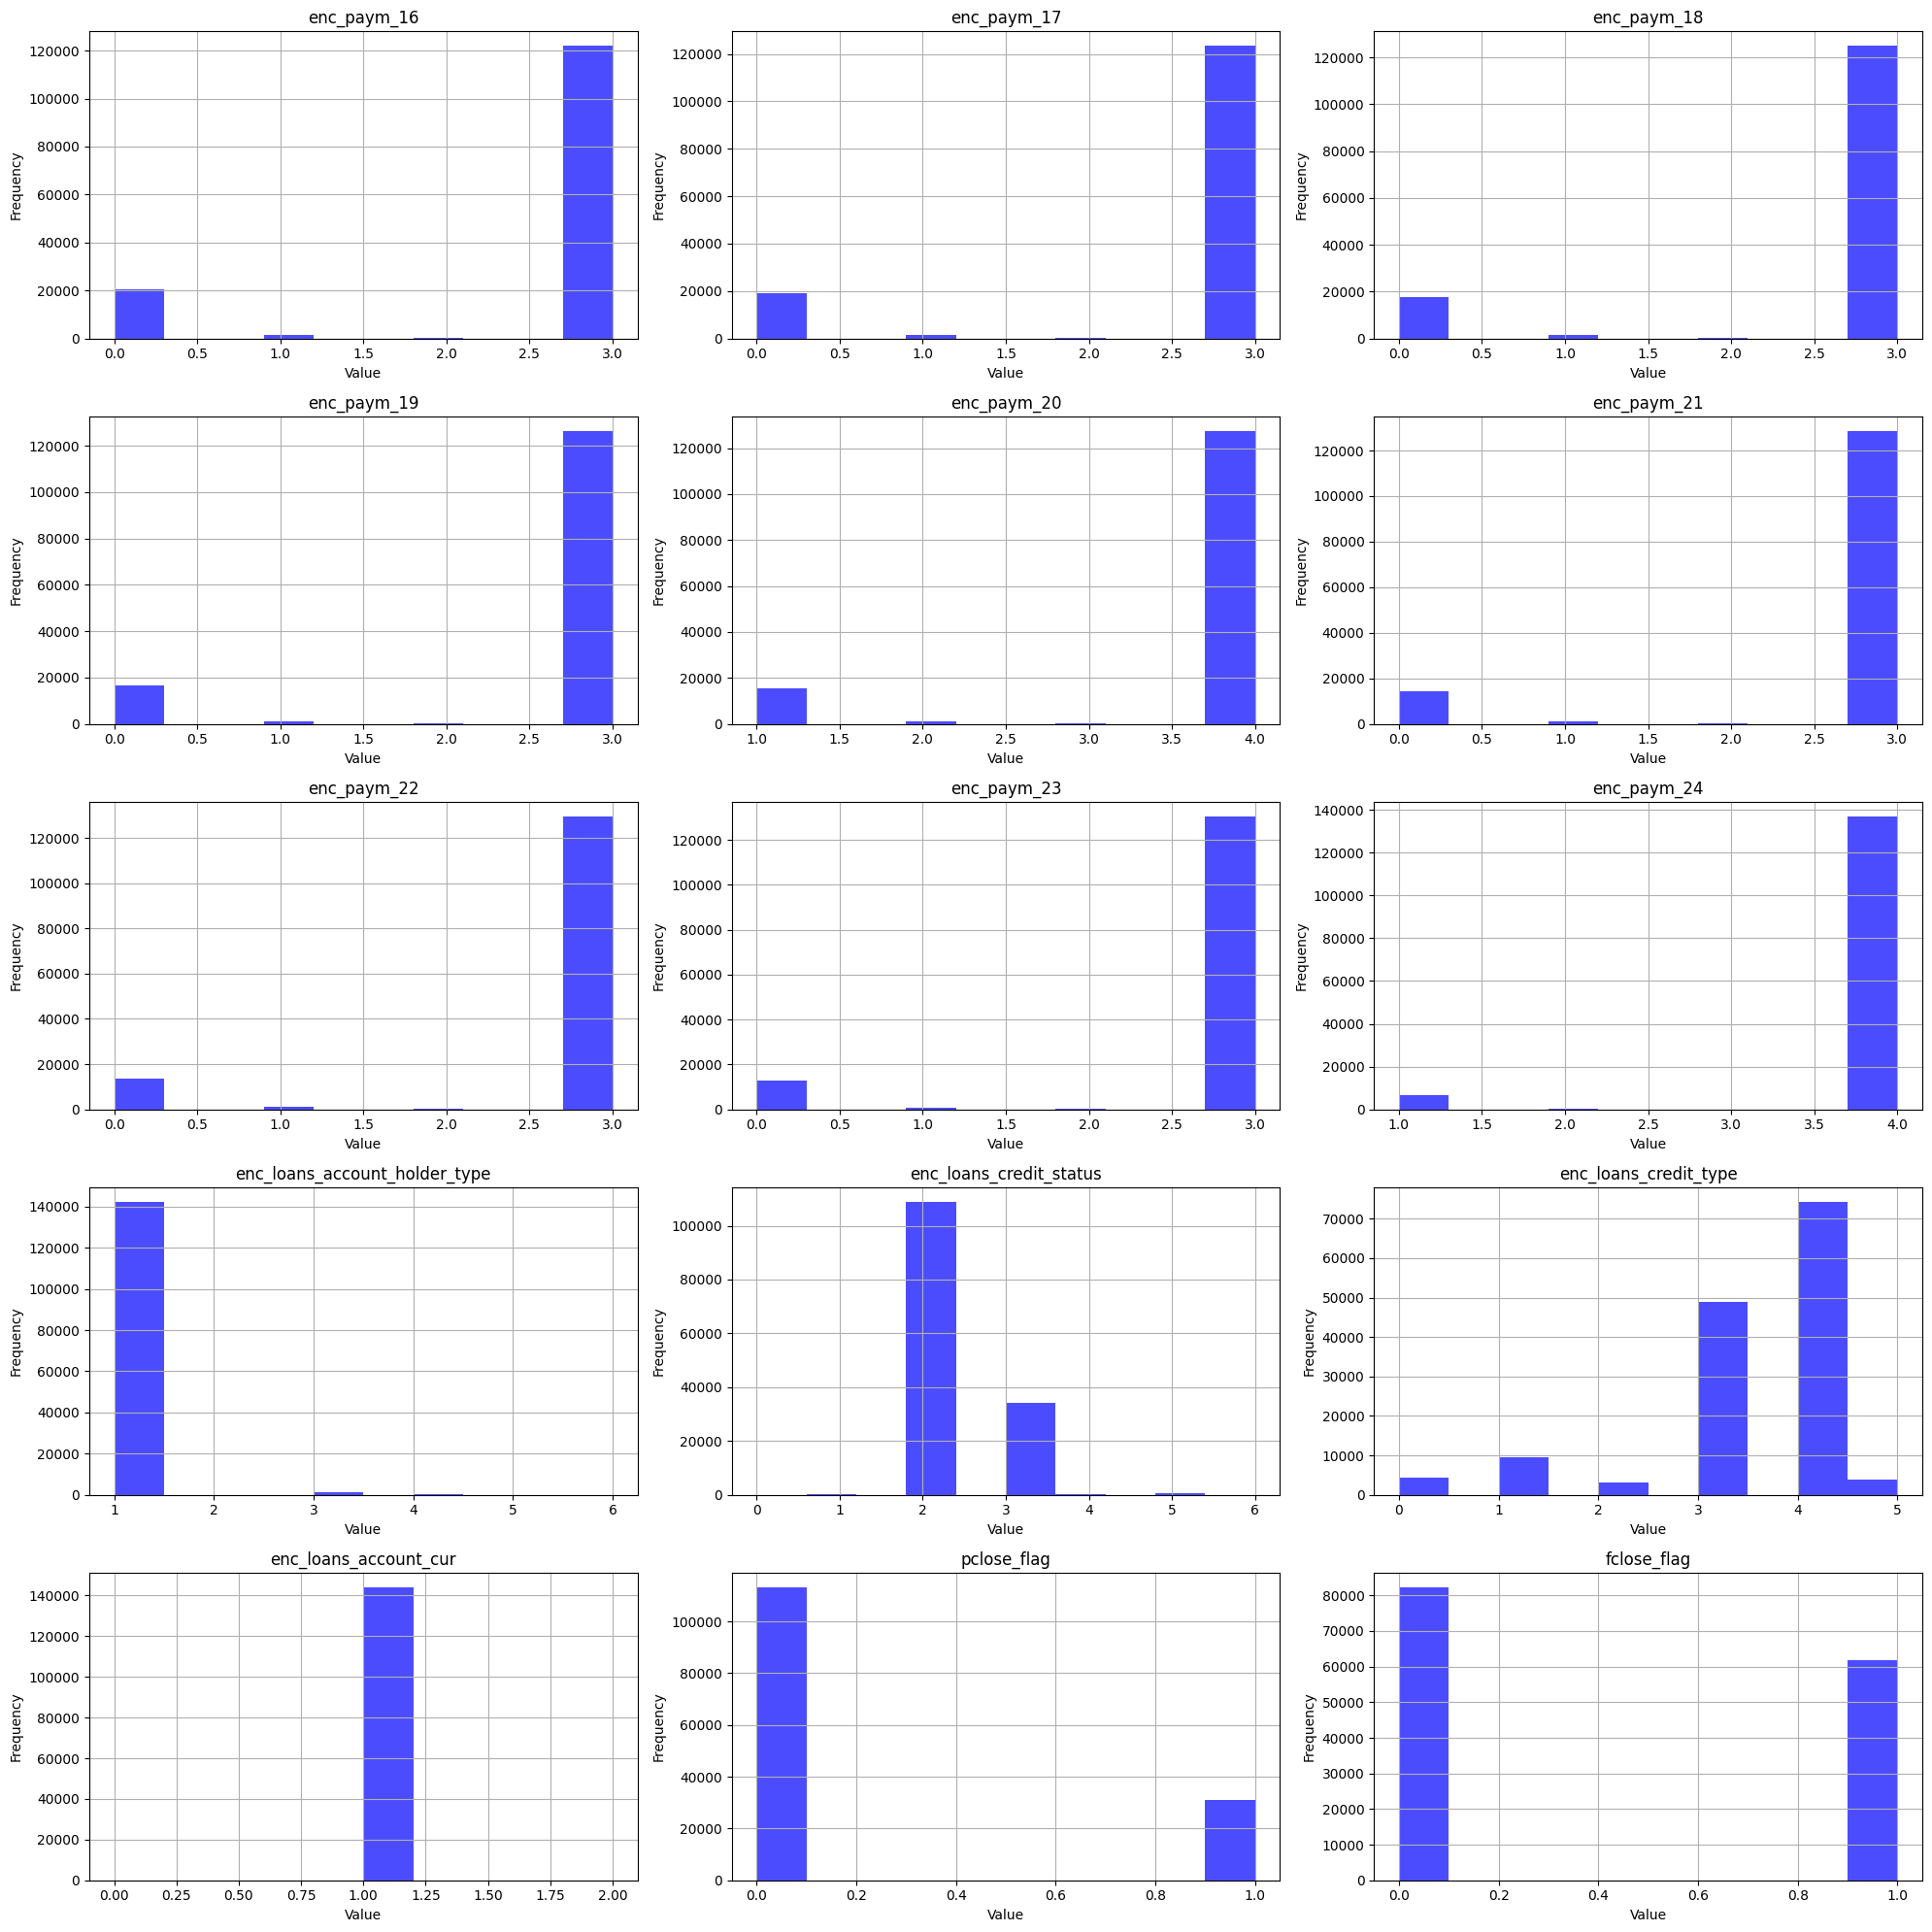

In [19]:
num_rows = 5
num_cols = 3

columns_to_plot = df_train.columns[45:60]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

axes_flat = axes.flatten()

for i, column in enumerate(columns_to_plot):
    ax = axes_flat[i]
    df_train[column].hist(ax=ax, color='blue', alpha=0.7)
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

for i in range(len(columns_to_plot), num_rows * num_cols):
    axes_flat[i].remove()

plt.tight_layout()
plt.show()

In [5]:
X = df_train.drop('flag', axis=1)
y = df_train['flag']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

def eval_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
    
    print("Model:", classifier.__class__.__name__)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("------------------------------------------")

# Evaluate models
for name, model in models.items():
    print("Training and evaluating", name)
    eval_model(model, X_train_scaled, y_train_smote, X_test_scaled, y_test)

Training and evaluating Logistic Regression
Model: LogisticRegression
Accuracy: 0.6758904261821415
Precision: 0.0597473540457494
Recall: 0.5185185185185185
F1 Score: 0.10714832389407623
ROC AUC Score: 0.6403577125214349
------------------------------------------
Training and evaluating Random Forest
Model: RandomForestClassifier
Accuracy: 0.9408512529866089
Precision: 0.06577480490523968
Recall: 0.0437037037037037
F1 Score: 0.052514463729417
ROC AUC Score: 0.6040017297634779
------------------------------------------
Training and evaluating Gradient Boosting
Model: GradientBoostingClassifier
Accuracy: 0.7735733733400011
Precision: 0.0715725806451613
Recall: 0.42074074074074075
F1 Score: 0.12233469739392634
ROC AUC Score: 0.6586907465137462
------------------------------------------


In [26]:
logreg = LogisticRegression()

# Initialize RFE
rfe = RFE(estimator=logreg, n_features_to_select=20)  # Select top 20 features

# Fit RFE
rfe.fit(X_train, y_train)

# Selected features using RFE
selected_features_rfe = X_train.columns[rfe.support_]

# Initialize Random Forest model
rf = RandomForestClassifier()

# Fit Random Forest
rf.fit(X_train, y_train)

# Feature importance
feature_importance_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Selected top 20 features based on feature importance
selected_features_rf = feature_importance_rf[:20].index

print("Selected Features (RFE):", selected_features_rfe)
print("\nSelected Features (Random Forest):", selected_features_rf)

C:\Users\zhana\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\zhana\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Selected Features (RFE): Index(['pre_loans_max_overdue_sum', 'pre_loans3060', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util',
       'is_zero_over2limit', 'enc_paym_1', 'enc_paym_2', 'enc_paym_4',
       'enc_paym_8', 'enc_paym_15', 'enc_paym_17', 'enc_paym_18',
       'enc_paym_19', 'enc_loans_credit_type', 'pclose_flag'],
      dtype='object')

Selected Features (Random Forest): Index(['pre_loans_credit_limit', 'pre_loans_credit_cost_rate',
       'pre_since_confirmed', 'pre_util', 'pre_loans_next_pay_summ',
       'pre_pterm', 'pre_loans_outstanding', 'pre_since_opened', 'pre_fterm',
       'pre_till_pclose', 'enc_loans_credit_type', 'pre_till_fclose',
       'enc_paym_1', 'enc_paym_2', 'enc_paym_0', 'enc_paym_3', 'enc_paym_4',
       'enc_paym_5', 'enc_paym_6', 'pre_loans_max_overdue_sum'],
      dtype='object')


In [33]:
selected_features = ['pre_loans_credit_limit', 'pre_loans_credit_cost_rate',
                     'pre_since_confirmed', 'pre_util', 'pre_loans_next_pay_summ',
                     'pre_pterm', 'pre_loans_outstanding', 'pre_since_opened',
                     'pre_fterm', 'pre_till_pclose', 'enc_loans_credit_type',
                     'pre_till_fclose', 'enc_paym_1', 'enc_paym_2', 'enc_paym_0',
                     'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6',
                     'pre_loans_max_overdue_sum']

X_selected = df_train[selected_features]
y_selected = df_train['flag']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.25, random_state=77)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Print evaluation metrics
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("------------------------------------------")

C:\Users\zhana\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\zhana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Logistic Regression
Accuracy: 0.9625
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC Score: 0.6460
------------------------------------------
Model: Gradient Boosting
Accuracy: 0.9625
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC Score: 0.7040
------------------------------------------
Model: XGBoost
Accuracy: 0.9625
Precision: 0.5714
Recall: 0.0030
F1 Score: 0.0059
ROC AUC Score: 0.7002
------------------------------------------
[LightGBM] [Info] Number of positive: 3804, number of negative: 104178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 107982, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035228 -> initscore=-3.310048
[LightGBM] [Info] Start training 

C:\Users\zhana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
df_train.flag.value_counts()

flag
0    138822
1      5154
Name: count, dtype: int64

In [7]:
df_majority = df_train[df_train['flag'] == 0]
df_minority = df_train[df_train['flag'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority),    # Match number in majority class
                                 random_state=42)  # Reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [57]:
df_upsampled.shape

(277644, 60)

In [8]:
X = df_upsampled.drop('flag', axis=1)
y = df_upsampled['flag']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)

In [60]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Print evaluation metrics
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("------------------------------------------")

C:\Users\zhana\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.6369
Precision: 0.6368
Recall: 0.6472
F1 Score: 0.6420
ROC AUC Score: 0.6898
------------------------------------------
Model: Gradient Boosting
Accuracy: 0.6708
Precision: 0.6767
Recall: 0.6615
F1 Score: 0.6690
ROC AUC Score: 0.7374
------------------------------------------
Model: XGBoost
Accuracy: 0.7981
Precision: 0.7827
Recall: 0.8287
F1 Score: 0.8051
ROC AUC Score: 0.8813
------------------------------------------
[LightGBM] [Info] Number of positive: 103909, number of negative: 104324
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 208233, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499004 -> initscore=-0.003986
[LightGBM] [Info] Start trainin

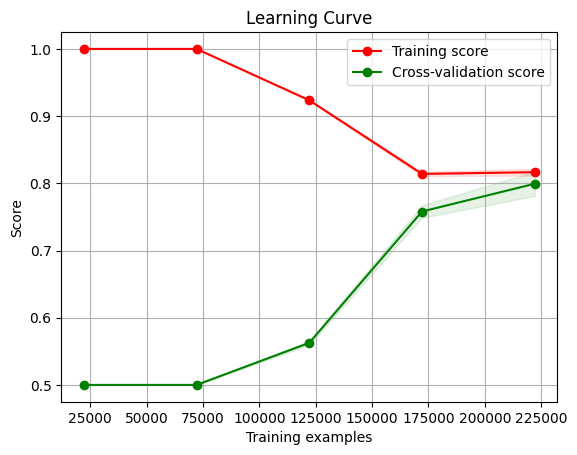

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(title, X, y, estimator = XGBClassifier(), ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Example usage:
# Replace estimator with your model and X, y with your data
plot_learning_curve("Learning Curve", X, y,estimator = XGBClassifier(),  cv=5)
plt.show()


In [68]:
%%time 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7],                # Maximum depth of a tree
    'learning_rate': [0.1, 0.01, 0.001],   # Learning rate
    'n_estimators': [100, 200, 300],       # Number of boosting rounds
    'min_child_weight': [1, 3, 5],         # Minimum sum of instance weight needed in a child
    'gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'subsample': [0.8, 0.9, 1.0],          # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 0.9, 1.0]    # Subsample ratio of columns when constructing each tree
}

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}") 


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
Evaluation Metrics:
Accuracy: 0.8732
Precision: 0.8412
Recall: 0.9220
F1 Score: 0.8798
ROC AUC Score: 0.9391
CPU times: total: 3d 21h 23min 14s
Wall time: 8h 16min 12s


In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

xgb_classifier_tuned = XGBClassifier(
    learning_rate=0.2169576570753119,
    n_estimators=620,
    max_depth=10,
    min_child_weight=1,
    gamma=0.24103475546202577,
    subsample=0.8891453301401647,b
    colsample_bytree=0.9902490366925919,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=42
)

xgb_classifier_tuned.fit(X_train, y_train)

y_pred = xgb_classifier_tuned.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, xgb_classifier_tuned.predict_proba(X_test)[:, 1])

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


Evaluation Metrics:
Accuracy: 0.9796
Precision: 0.9610
Recall: 1.0000
F1 Score: 0.9801
ROC AUC Score: 0.9953


In [11]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     34498
           1       0.96      1.00      0.98     34913

    accuracy                           0.98     69411
   macro avg       0.98      0.98      0.98     69411
weighted avg       0.98      0.98      0.98     69411



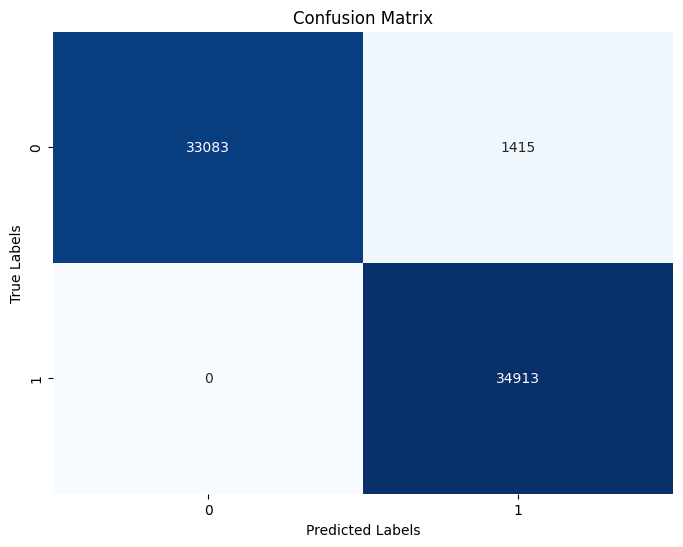

In [100]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [73]:
df_test.head()

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,7,16,6,8,0,11,2,0,1,0,...,3,3,3,4,1,2,0,1,0,1
1,7,10,17,8,8,11,10,2,3,0,...,3,3,3,4,1,2,3,1,0,1
2,3,9,2,14,7,15,8,4,3,0,...,1,1,0,4,1,3,4,1,0,0
3,7,9,2,10,8,8,16,4,2,0,...,3,3,3,4,1,2,4,1,0,0
4,19,5,7,8,1,11,6,1,4,0,...,3,3,3,4,1,2,1,1,0,1


In [96]:
df_test_without_id = df_test.drop(columns=['id'])

predicted_flag = xgb_classifier_tuned.predict(df_test_without_id)

results = pd.DataFrame({'id': df_test['id'], 'predicted_flag': predicted_flag})

results.head()
results.predicted_flag.value_counts()

predicted_flag
0    69193
1     5807
Name: count, dtype: int64

In [97]:
results.shape

(75000, 2)

In [103]:
results.sample(5)

,id,predicted_flag
34896,126974,0
12248,88018,0
41652,231626,0
40025,19840,0
24937,1482,0


In [101]:
# Save the results to a CSV file
results.to_csv('predicted_flags.csv', index=False)

In [86]:
results.predicted_flag.value_counts()

predicted_flag
0    54886
1    20114
Name: count, dtype: int64

In [79]:
X.head()

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,3,9,16,9,15,14,16,3,3,0,...,3,3,3,4,1,3,4,1,0,0
1,9,6,0,1,0,4,1,3,4,0,...,3,3,3,4,1,2,3,1,0,0
2,12,16,14,8,10,11,10,2,3,0,...,3,3,3,4,1,2,3,1,0,1
3,7,9,17,16,14,8,14,3,5,0,...,3,3,3,4,1,2,4,1,0,0
4,9,9,4,8,1,11,10,3,3,0,...,3,3,3,4,1,2,3,1,1,1


In [92]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'objective': 'binary:logistic',
        'nthread': 4,
        'scale_pos_weight': 1,
        'seed': 42
    }
    
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print('ROC AUC Score:', trial.value)
print("Best hyperparameters:", trial.params)


C:\Users\zhana\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-23 19:40:42,651] A new study created in memory with name: no-name-50e1d5f5-d2f0-4b7d-a78d-244ca5f1517c
[I 2024-03-23 19:41:57,030] Trial 0 finished with value: 0.9920825480872655 and parameters: {'learning_rate': 0.13168109811011477, 'n_estimators': 959, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.35073141908731686, 'subsample': 0.7013788084862547, 'colsample_bytree': 0.5111977351664243}. Best is trial 0 with value: 0.9920825480872655.
[I 2024-03-23 19:43:01,352] Trial 1 finished with value: 0.9748872882010586 and parameters: {'learning_rate': 0.10006288098121029, 'n_estimators': 891, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.1428901502323865, 'subsample': 0.532616532100797, 'colsample_bytree': 0.9996715600790482}. Be

Best trial:
ROC AUC Score: 0.9946856395654875
Best hyperparameters: {'learning_rate': 0.2169576570753119, 'n_estimators': 620, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.24103475546202577, 'subsample': 0.8891453301401647, 'colsample_bytree': 0.9902490366925919}


In [91]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/e9/db/f1641a99e1f95489baec8472d2c88c8f6b87f7be242a846864bd1a19c0f4/optuna-3.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/7f/50/9fb3a5c80df6eb6516693270621676980acd6d5a9a7efdbfa273f8d616c7/alembic-1.13.1-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy>=1.3.0 from https://files.pythonhosted.org/packages/4b/f8/c1fe26782e875a952f1bad265034185dbd888f6c55d4bb5f0f515e172b8d/SQLAlchemy-2.0.28-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/2b/8d/9f11d0b9ac521febb806e7f30dc5982d0f4f5821217712c59005fbc5c1e3/Mako-1.3.2-py3-no